<center>
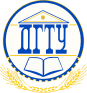
<br/>
<h5>ФЕДЕРАЛЬНОЕ ГОСУДАРСТВЕННОЕ БЮДЖЕТНОЕ ОБРАЗОВАТЕЛЬНОЕ УЧРЕЖДЕНИЕ ВЫСШЕГО ОБРАЗОВАНИЯ <br/> «ДОНСКОЙ ГОСУДАРСТВЕННЫЙ ТЕХНИЧЕСКИЙ УНИВЕРСИТЕТ» (ДГТУ)</h5>
</center>
<br/>
<p>Факультет «Отдел магистратуры»</p>
<p>Кафедра «Вычислительные системы и информационная безопасность»</p>
<br/>
<center>
<p>Отчёт</p>
<p>Лабораторная работа № 1</p>
<h3>по дисциплине «Интеллектуальные системы обеспечения информационной безопасности»</h3>
<h1>«Задача подбора пароля с использованием иммунного алгоритма»</h1>
</center>

## 1. Подготовка среды

### 1.1. Установка внешних зависимостей

In [24]:
# Для установки пакета DEAP (Distributed Evolutionary Algorithms in Python) работы с генетическими алгоритмами в рабочую область
# Предоставляет средства для определения операторов алгоритма и регистрации функций, используемых в генетическом алгоритме
!pip install deap

### 1.2. Подключение директив

In [34]:
# Подключение внешних модулей
import string
import random
import matplotlib.pyplot as plt
from deap import base, algorithms
from deap import creator
from deap import tools

## 2. Решение задачи

### 2.1. Задание переменных и входных данных

In [35]:
# Константы задачи
TARGET_PASSWORD = input("Исследуемый пароль для подбора: ")       # Исследуемый пароль
PASSWORD_LENGTH = len(TARGET_PASSWORD)                # Длина пароля

# Определение алфавита символов
ALPHABET = string.ascii_letters + string.digits + string.punctuation

# Константы иммунного алгоритма
POPULATION_SIZE = int(input("Укажите кол-во индивидуумов в популяции: "))          # РЕКОМЕНДУЕТСЯ 500
P_CROSSOVER = float(input("Укажите вероятность скрещивания (0.1 - 1.0): "))       # РЕКОМЕНДУЕТСЯ 0.9
P_MUTATION = float(input("Укажите вероятность мутации индивида (0.1 - 1.0): "))   # РЕКОМЕНДУЕТСЯ 0.1
MAX_GENERATIONS = int(input("Укажите максимальное кол-во поколений: "))           # РЕКОМЕНДУЕТСЯ 100

# POPULATION_SIZE = 500
# P_CROSSOVER = 0.9
# P_MUTATION = 0.1
# MAX_GENERATIONS = 100

# Для воспроизводимости эксперемента
RANDOM_SEED = 42
random.seed(RANDOM_SEED)

Исследуемый пароль для подбора: VicEter&_16#12!


### 2.2. Описание классов решаемой задачи
Обозначения условия решения задачи

In [36]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,)) # устанавливается одно значение фитнеса с весом 1.0, что указывает на максимизацию значения при решении задачи
creator.create("Individual", list, fitness=creator.FitnessMax) # представляет создание класса отдельного индивида

### 2.3. Описание необходимых функций генетики
1. Функция случайной генерации символа из алфавита
2. Функция генерации индивидума на основе длинны входного пароля и функции;генерации случайного символа алфавита;
3. Функция генерации популяции на основе ранее полученных индивилумов.

In [37]:
toolbox = base.Toolbox()

# Генерация случайного символа из алфавита
toolbox.register("generate_symbol", random.choice, ALPHABET)
# Генерация случайного индивидуума (пароля)
toolbox.register("individualCreator", tools.initRepeat, creator.Individual, toolbox.generate_symbol, PASSWORD_LENGTH)
# Генерация популяции индивидумов
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

### 2.4. Определение целевой функции решаемой задачи



In [38]:
def passwordFitness(individual):
    """
      Сравнение индивидуума с заданным паролем
      Использует функцию zip для итерации по символам индивидуума и символам целевого пароля (TARGET_PASSWORD). Затем она сравнивает каждую пару символов с помощью условия if i == j. Если символы совпадают, увеличивается счетчик fitness на 1.
      param : individual - индивидум (особь)
      returns : fitness (кортеж) - количество совпадающих символов между индивидуумом и целевым паролем
    """
    fitness = sum(1 for i, j in zip(individual, TARGET_PASSWORD) if i == j)
    return creator.FitnessMax((fitness,))

### 2.5. Регистрация генетических операторов

In [39]:
# Функция для вычисления фитнес-значения (меры пригодности) каждого индивидуума в популяции
toolbox.register(
    "evaluate",
    passwordFitness # passwordFitness принимает индивидуума в качестве аргумента и возвращает его фитнес-значение
)

# Функциявыбора индивидумов из популяции
toolbox.register(
    "select",
    tools.selTournament,  # используется турнирный выбор
    tournsize=3           # выбирвется 3 случайных индивидума, после чего из них на осноеве фитнесс-значения выбирается лучший
)

# Функция оператора скрещивания (кроссовер)
toolbox.register(
    "mate",
    tools.cxTwoPoint # используется двухточечное скрещивание, при котором выбираются две точки разделения в геноме индивидуумов и происходит обмен соответствующих участков между родителями для создания потомства
)

# Функция оператора мутации
toolbox.register(
    "mutate",
    tools.mutShuffleIndexes, # используется метод перестановки который случайным образом меняет порядок элементов в геноме индивидуума
    indpb=1.0/PASSWORD_LENGTH # с некоторой вероятностью (indpb)
)

### 2.6. Тело иммунного алгоритма

In [43]:
# Инициализация списка индивидумов
population = toolbox.populationCreator(n=POPULATION_SIZE)

# Сбор статистических данных популции  которая извлекает значения фитнеса индивидуумов
stats = tools.Statistics(lambda ind: ind.fitness.values[0])
stats.register("max", max) # регистрируется статистика "max" для вычисления максимального значения фитнеса
stats.register("avg", lambda pop: sum(ind.fitness.values[0] for ind in pop if hasattr(ind, 'fitness')) / len(pop))

# Для записи результатов и статистики эволюции алгоритма
logbook = tools.Logbook()
logbook.header = ["gen", "max", "avg"]

max_fitness_values = []
avg_fitness_values = []

for gen in range(MAX_GENERATIONS):
    offspring = algorithms.varAnd(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION)

    # Вывод потомков
    print(f"\nПоколение №{gen+1}:")
    for idx, ind in enumerate(offspring):
        if idx < len(population):
            print(f"Индивидуум {idx+1} >>> [ {''.join(ind)} ]")
        else:
            print(f"Индивидуум {idx+1-len(population)} >>> [ {''.join(ind)} ]")

    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness = fit

    population[:] = toolbox.select(offspring, k=len(population))

    # Вывод результатов скрещивания
    best_ind = tools.selBest(population, 1)[0]
    print(f"Лучший индивидуум поколения {gen+1}: [ {''.join(best_ind)} ]")
    print("-" * 50)

    record = stats.compile(population)
    logbook.record(gen=gen, **record)

    max_fitness_values.append(record["max"])
    avg_fitness_values.append(record["avg"])

best_individual = tools.selBest(population, 1)[0]
best_password = ''.join(best_individual)

print("Лучший найденный пароль:", best_password)

Выходные данные были обрезаны до нескольких последних строк (5000).
Индивидуум 40 >>> [ VicEter&_16#12! ]
Индивидуум 41 >>> [ VicEter&_16#12! ]
Индивидуум 42 >>> [ VicEter&_16#12! ]
Индивидуум 43 >>> [ VicEter&_16#12! ]
Индивидуум 44 >>> [ VicEter&_16#12! ]
Индивидуум 45 >>> [ VicEter&_16#12! ]
Индивидуум 46 >>> [ VicEter&_16#12! ]
Индивидуум 47 >>> [ VicEter&_16#12! ]
Индивидуум 48 >>> [ VicEter&_16#12! ]
Индивидуум 49 >>> [ VicEter&_16#12! ]
Индивидуум 50 >>> [ VicEter&_16#12! ]
Индивидуум 51 >>> [ VicEter&_16#12! ]
Индивидуум 52 >>> [ VicEter&_16#12! ]
Индивидуум 53 >>> [ VicEter&_16#12! ]
Индивидуум 54 >>> [ VicEter&_16#12! ]
Индивидуум 55 >>> [ VicEter&_16#12! ]
Индивидуум 56 >>> [ ticEVer&_16#12! ]
Индивидуум 57 >>> [ VicEter&_16#12! ]
Индивидуум 58 >>> [ VicEter&_16#12! ]
Индивидуум 59 >>> [ VicEter&_16#12! ]
Индивидуум 60 >>> [ VicEter&_16#12! ]
Индивидуум 61 >>> [ VicEter&_16#12! ]
Индивидуум 62 >>> [ VicEter&_16#12! ]
Индивидуум 63 >>> [ VicEter&_16#12! ]
Индивидуум 64 >>> [ 

### 2.6. Графическое представление эволюции подбираемого пароля

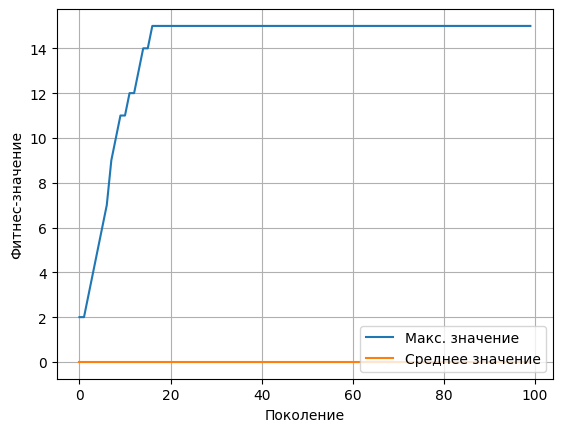

In [44]:
gen = range(MAX_GENERATIONS)
plt.plot(gen, max_fitness_values, label="Макс. значение")
plt.plot(gen, avg_fitness_values, label="Среднее значение")
plt.xlabel("Поколение")
plt.ylabel("Фитнес-значение")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

<p>Выполнил студент группы МИБ21: Кодацкий Н. М.</p>   
<p>Проверила децент кф "ВСиИБ": Полуян А. Ю.</p>
<br/>
<center>
<p>г. Ростов-на-Дону 2023 г</p>
</center>